<a href="https://colab.research.google.com/github/MohammadJamali/RecommenderSystems/blob/master/COFILS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Datasets

In [0]:
# Prepare folders and directories

!cd /content
!rm -R *

!mkdir -p datasets

In [2]:
# Prepare MovieLens 100K movie ratings dataset
!mkdir -p datasets
!wget -c -t 0 "http://files.grouplens.org/datasets/movielens/ml-100k.zip" -O datasets/ml-100k.zip
!unzip datasets/ml-100k.zip -d datasets
!rm datasets/ml-100k.zip

!mkdir -p "dataset_splited/ml-100k"
!mkdir -p "dataset_transformed/ml-100k"

dataset_sep='\t'
dataset_name = 'ml-100k'
dataset_address = '/content/datasets/ml-100k/u.data'
dataset_columns = ['user', 'movie', 'rate', 'time_stamp']
dataset_row_name = 'user'
dataset_col_name = 'movie'
dataset_val_name = 'rate'

--2019-06-08 21:10:00--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘datasets/ml-100k.zip’

datasets/ml-100k.zi 100%[===================>]   4.70M  26.8MB/s    in 0.2s    

2019-06-08 21:10:00 (26.8 MB/s) - ‘datasets/ml-100k.zip’ saved [4924029/4924029]

Archive:  datasets/ml-100k.zip
   creating: datasets/ml-100k/
  inflating: datasets/ml-100k/allbut.pl  
  inflating: datasets/ml-100k/mku.sh  
  inflating: datasets/ml-100k/README  
  inflating: datasets/ml-100k/u.data  
  inflating: datasets/ml-100k/u.genre  
  inflating: datasets/ml-100k/u.info  
  inflating: datasets/ml-100k/u.item  
  inflating: datasets/ml-100k/u.occupation  
  inflating: datasets/ml-100k/u.user  
  inflating: datasets/ml-100k/u1.base  
  inflati

In [3]:
import os
import pandas as pd

from sklearn.preprocessing import LabelEncoder

dataset = pd.read_csv(dataset_address, header=None, sep=dataset_sep, names = dataset_columns, engine='python')

label_encoder_row = LabelEncoder()
dataset[dataset_row_name] = label_encoder_row.fit_transform(dataset[dataset_row_name])

label_encoder_col = LabelEncoder()
dataset[dataset_col_name] = label_encoder_col.fit_transform(dataset[dataset_col_name])

dataset_row_count = int(dataset[[dataset_row_name]].max()) + 1
dataset_col_count = int(dataset[[dataset_col_name]].max()) + 1

print(' - DataSet has been fully loaded with this information:')
print('\tDataSet contains %d %s and %d %s' %
      (dataset_row_count, dataset_row_name, dataset_col_count, dataset_col_name))


 - DataSet has been fully loaded with this information:
	DataSet contains 943 user and 1682 movie


# Autoencoder-COFILS

In this section, we present our A-COFILS architecture based on COFILS methodology. Our proposed method is divided in five steps: matrices creation, data normalization, Autoencoder architecture selection, generating supervised data set and applying a regressor.

## (i) Matrices Creation

The first step is the creation of the user-item matrix based on the ratings of the training set. This matrix and its transpose are used, respectively, as user and item matrices where the latent variables will be extracted.



### ***Please check out 'Prepare Datasets' Section***




In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.1)

## (ii) Data Normalization

The next step is the choose of the ratings matrices normalizations. Each of the constructed matrices, user and item, can be normalized with different normalization types, such as normalization by the average user or item rating. Additionally, instead of using the actual user rating as the target for the regression task, it can also be normalized with normalization by the average user or item rating (Braida et al., 2015). Note that a major difference between COFILS and this work is the untying of the matrix normalization from the target normalization. This flexibilize the methodology and was able to improve the results even using SVD as latent variable extraction technique for some data sets. The **missing ratings from the ratings matrix are filled with zero**. Regarding the normalization chosen, previous experiments indicate that the system performed better with no normalization in ratings matrix and normalization by the item mean in ratings that is used as the regression target.

1.   Fill missing ratings with zero
2.   No matrix normalization, Target normalization by item mean



In [5]:
import warnings
import numpy as np

from IPython.core import display as ICD
from sklearn.preprocessing import MinMaxScaler
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

def group_mean_normalize(matrix, mean, group_by):
  mean_normalized_matrix = pd.DataFrame()
  for group_id, group in matrix.groupby(by=[group_by]):
    mean_normalized = group.copy()
    mean_normalized[dataset_val_name] = mean_normalized[dataset_val_name] - mean.iloc[group_id][0]
    mean_normalized_matrix = mean_normalized_matrix.append(group.reset_index())

    print('\rGroup %d has been fully normilized (%0.2f%%)' %
          (group_id, (group_id / dataset_col_count) * 100), end='')
  print('\rGroup %d has been fully normilized (%0.2f%%)' % (group_id, 100))
  return mean_normalized_matrix


print('Normalizing dataset by its column\'s mean:')

# normalize each column of matrix by the same column's mean
# we compute columns mean from original dataset so we can use same
# mean for test and train if necessary
global_mean = dataset.groupby(by=[dataset_col_name])[[dataset_val_name]].mean()

mean_normalized_train = group_mean_normalize(train, global_mean, dataset_col_name)
mean_normalized_test = group_mean_normalize(test, global_mean, dataset_col_name)

print('\n\tMean Normalized Train\n')
print('\nHead:')
ICD.display(mean_normalized_train.head())
print('\nSummery of \'%s\':' % dataset_val_name)
ICD.display(mean_normalized_train[[dataset_val_name]].describe())


print('Normalizing dataset by its column\'s max:')

# # normalize each column of matrix by the same column's max
# scaled_normalized_dataset = pd.DataFrame()
# for group_id, group in train.groupby(by=[dataset_col_name]):
#   max = group[dataset_val_name].max().max()
#   scaled_normalized = group.copy()
#   scaled_normalized[dataset_val_name] = scaled_normalized[dataset_val_name].apply(lambda x: x / max)
#   scaled_normalized_dataset = scaled_normalized_dataset.append(scaled_normalized.reset_index())

#   print('\rGroup %d has been fully normilized (%0.2f%%)' %
#         (group_id, (group_id / dataset_col_count) * 100), end='')
# print('\rGroup %d has been fully normilized (%0.2f%%)' % (group_id, 100))

# normalize whole matrix considering the global max which is 5 in mk-100k
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(dataset)
scaled_normalized_train = pd.DataFrame(scaler.transform(train), columns=dataset_columns)
scaled_normalized_test = pd.DataFrame(scaler.transform(test), columns=dataset_columns)

print('\nScaled Normalized Train\n')
print('\nHead')
ICD.display(scaled_normalized_train.head())
print('\nSummery of \'%s\':' % dataset_val_name)
ICD.display(scaled_normalized_train[[dataset_val_name]].describe())

Normalizing dataset by its column's mean:
Group 1681 has been fully normilized (100.00%)
Group 1676 has been fully normilized (100.00%)

	Mean Normalized Train


Head:


,index,user,movie,rate,time_stamp
0,7067,193,0,4,879539127
1,71267,462,0,1,890453075
2,80525,402,0,4,879785974
3,46976,304,0,5,886323153
4,99359,444,0,3,891199749



Summery of 'rate':


,rate
count,90000.000000
mean,3.531656
std,1.125231
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


Normalizing dataset by its column's max:

Scaled Normalized Train


Head


,user,movie,rate,time_stamp
0,0.751592,0.048186,0.75,0.276045
1,0.731423,0.227841,0.50,0.347652
2,0.921444,0.143367,0.25,0.526098
3,0.441614,0.001190,0.75,0.265147
4,0.759023,0.012493,1.00,0.273164



Summery of 'rate':


,rate
count,90000.000000
mean,0.632914
std,0.281308
min,0.000000
25%,0.500000
50%,0.750000
75%,0.750000
max,1.000000


In [6]:
from scipy.sparse import csr_matrix

def sparce_to_dense(matrix, row_name, col_name, val_name, row_count, col_count):
  matrix_val = np.array(matrix[[val_name]]).reshape(-1)
  matrix_row = np.array(matrix[[row_name]]).reshape(-1)
  matrix_col = np.array(matrix[[col_name]]).reshape(-1)
  matrix_dense = csr_matrix((matrix_val, (matrix_row, matrix_col)), 
                            shape=(row_count, col_count))
  matrix_dense = matrix_dense.todense()
  return matrix_dense

scaled_normalized_train_dense = sparce_to_dense(scaled_normalized_train, dataset_row_name, dataset_col_name, dataset_val_name, dataset_row_count, dataset_col_count)
scaled_normalized_test_dense = sparce_to_dense(scaled_normalized_test, dataset_row_name, dataset_col_name, dataset_val_name, dataset_row_count, dataset_col_count)

row_col_scaled_normalized_matrix = np.array(scaled_normalized_train_dense)
col_row_scaled_normalized_matrix = np.array(scaled_normalized_train_dense).transpose()

print('Train set with shape: %s' % str(scaled_normalized_train.shape))
print('Test set with shape: %s' % str(scaled_normalized_test.shape))

print('Train dense matrix with shape: %s' % str(scaled_normalized_train_dense.shape))
print('Test dense matrix with shape: %s' % str(scaled_normalized_test_dense.shape))

del scaled_normalized_train_dense

Train set with shape: (90000, 4)
Test set with shape: (10000, 4)
Train dense matrix with shape: (943, 1682)
Test dense matrix with shape: (943, 1682)


## (iii) Autoencoder architecture selection

After the normalization process, it is needed to adjust the users and items matrix range to the used Autoencoder activation function range. Later, a Denoising Autoencoder is trained for users features using the normalized user matrix and another is trained for the item features used the normalized item matrix.

The figure 8 shows the five architectures that yield the best results. Based on that, the chosen architecture are two stacked layers with 900 neurons in the first layer and 50 in the second.

Both is trained using regular backpropagation algorithm using bellow specification for all stacked layers:

1.   learning rate of γ=0.01
2.   Corruption level v=50%
3.   Sigmoid activation function
4.   L2 regularization λ=0.001
5.   Squared error loss function



In [7]:
from keras import regularizers, losses, activations

learning_rate = 0.01
corruption_level = 0.50
activation_function = activations.sigmoid
regularization = regularizers.l2(0.001)
loss_function = losses.mean_squared_error

Using TensorFlow backend.


In [8]:
from keras.layers import Dense, Dropout
from keras import Input, Model
from keras import optimizers, backend
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

backend.clear_session()

def create_denoising_autoencoder(input_len, 
                                 hidden_dim,
                                 corruption_level,
                                 activation_function,
                                 regularization,
                                 learning_rate,
                                 loss_function,
                                 name = None):
  name = name + "_" if name is not None else ''
  layer_input = Input(shape=(input_len,),
                      name=name + 'input')
  encoder_dropout = Dropout(corruption_level,
                            name=name+'dropout')
  encoder = Dense(units=hidden_dim,
                  activation=activation_function,
                  kernel_regularizer=regularization,
                  name=name + 'encoder')
  
  decoder = Dense(units=input_len,
                  activation=activation_function,
                  kernel_regularizer=regularization,
                  name=name + 'decoder')
  
  DAE = decoder(encoder(encoder_dropout(layer_input)))
  DAE = Model(layer_input, DAE)
  DAE.compile(optimizer=optimizers.Adam(lr=learning_rate), loss=loss_function)
  
  encoder = encoder(encoder_dropout(layer_input))
  encoder = Model(layer_input, encoder)
  
  return encoder, DAE

row_first_encoder, row_first_DAE = \
  create_denoising_autoencoder(dataset_col_count,
                               900,
                               corruption_level,
                               activation_function,
                               regularization,
                               learning_rate,
                               loss_function,
                               'row_first')

col_first_encoder, col_first_DAE = \
  create_denoising_autoencoder(dataset_row_count,
                               900,
                               corruption_level,
                               activation_function,
                               regularization,
                               learning_rate,
                               loss_function,
                               'col_first')

row_second_encoder, row_second_DAE = \
  create_denoising_autoencoder(900,
                               50,
                               corruption_level,
                               activation_function,
                               regularization,
                               learning_rate,
                               loss_function,
                               'row_second')

col_second_encoder, col_second_DAE = \
  create_denoising_autoencoder(900,
                               50,
                               corruption_level,
                               activation_function,
                               regularization,
                               learning_rate,
                               loss_function,
                               'col_second')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


- Fitting denoising auto-encoder for rows at 2019-06-08 21:10:20
Instructions for updating:
Use tf.cast instead.
	First DAE layer trained with mean_squared_error = 2038.9885

	Row first denoising auto-encoder



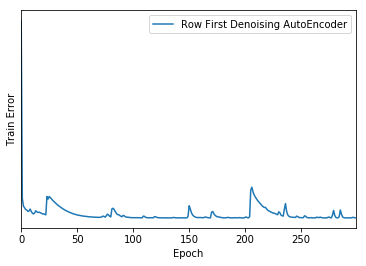

	Row second DAE trained with mean_squared_error = 0.0000

	Row Second Denoising AutoEncoder



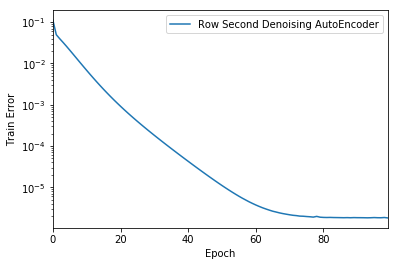

- Fitting denoising auto-encoder for cols at 2019-06-08 21:11:13
	Col first DAE trained with mean_squared_error = 2039.0001

	Col First Denoising AutoEncoder



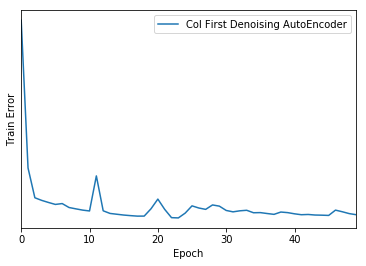

	Col second DAE trained with mean_squared_error = 0.0001

	Col Second Denoising AutoEncoder



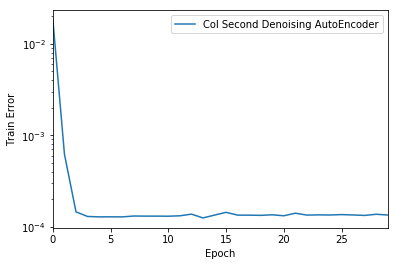

In [9]:
import datetime
import matplotlib.pyplot as plt

loss_function_name = loss_function.__name__ if hasattr(loss_function, '__name__') else 'loss'

print('- Fitting denoising auto-encoder for rows at ' +
      str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

row_first_DAE_history = row_first_DAE.fit(row_col_scaled_normalized_matrix,
                                          row_col_scaled_normalized_matrix,
                                          verbose=0,
                                          epochs=300,
                                          shuffle=True)

loss = row_first_DAE_history.history['loss']
print('\tFirst DAE layer trained with %s = %.4f' % (loss_function_name, loss[-1]))
pd.Series(row_first_DAE_history.history['loss']) \
  .plot(logy=True, legend=True, label='Row First Denoising AutoEncoder')
plt.xlabel("Epoch")
plt.ylabel("Train Error")
print('\n\tRow first denoising auto-encoder\n')
plt.show()

row_first_DAE_output = row_first_encoder.predict(row_col_scaled_normalized_matrix)

row_second_DAE_history = row_second_DAE.fit(row_first_DAE_output,
                                            row_first_DAE_output,
                                            verbose=0,
                                            epochs=100,
                                            shuffle=True)

loss = row_second_DAE_history.history['loss']
print('\tRow second DAE trained with %s = %.4f' % (loss_function_name, loss[-1]))
pd.Series(loss) \
  .plot(logy=True, legend=True, label='Row Second Denoising AutoEncoder')
plt.xlabel("Epoch")
plt.ylabel("Train Error")
print('\n\tRow Second Denoising AutoEncoder\n')
plt.show()

print('- Fitting denoising auto-encoder for cols at ' +
      str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

col_first_DAE_history = col_first_DAE.fit(col_row_scaled_normalized_matrix,
                                          col_row_scaled_normalized_matrix,
                                          verbose=0,
                                          epochs=50,
                                          shuffle=True)

loss = col_first_DAE_history.history['loss']
print('\tCol first DAE trained with %s = %.4f' % (loss_function_name, loss[-1]))
pd.Series(loss) \
  .plot(logy=True, 
        legend=True, 
        label='Col First Denoising AutoEncoder')
plt.xlabel("Epoch")
plt.ylabel("Train Error")
print('\n\tCol First Denoising AutoEncoder\n')
plt.show()

col_first_DAE_output = col_first_encoder.predict(col_row_scaled_normalized_matrix)

col_second_DAE_history = col_second_DAE.fit(col_first_DAE_output,
                                            col_first_DAE_output,
                                            verbose=0,
                                            epochs=30,
                                            shuffle=True)

loss = col_second_DAE_history.history['loss']
print('\tCol second DAE trained with %s = %.4f' % (loss_function_name, loss[-1]))
pd.Series(loss) \
  .plot(logy=True, 
        legend=True, 
        label='Col Second Denoising AutoEncoder')
plt.xlabel("Epoch")
plt.ylabel("Train Error")
print('\n\tCol Second Denoising AutoEncoder\n')
plt.show()


## (iv) Generating Supervised Dataset
After, the features obtained from both Autoencoders are mapped just like in the regular COFILS methodology process mentioned early. To do that, the respective vector of features from an user u are combined with the feature vector of an item i and the rating r, or the normalized rating, given by user u for item i are used as the target for regression.

In [10]:
print('- Generating supervised train dataset from auto encoder hidden layers:')

row_profile = row_second_encoder.predict(row_first_encoder.predict(row_col_scaled_normalized_matrix))
col_profile = col_second_encoder.predict(col_first_encoder.predict(col_row_scaled_normalized_matrix))

supervised_dataset_train = pd.DataFrame()
sample_count = 0
for index, sample in scaled_normalized_train.iterrows():  
  new_sample = row_profile[int(sample[dataset_row_name])]
  new_sample = np.append(new_sample, col_profile[int(sample[dataset_col_name])], axis = 0)
  new_sample = np.reshape(new_sample, (1, 100))
  
  supervised_dataset_train = supervised_dataset_train.append(pd.DataFrame(new_sample))
  
  print('\r%.02f%% complete' % ((sample_count / scaled_normalized_train.shape[0]) * 100), end='')
  sample_count +=1
  
  
print('\n- Generating supervised test dataset from auto encoder hidden layers:')
supervised_dataset_test = pd.DataFrame()
sample_count = 0
for index, sample in scaled_normalized_test.iterrows():  
  new_sample = row_profile[int(sample[dataset_row_name])]
  new_sample = np.append(new_sample, col_profile[int(sample[dataset_col_name])], axis = 0)
  new_sample = np.reshape(new_sample, (1, 100))
  
  supervised_dataset_test = supervised_dataset_test.append(pd.DataFrame(new_sample))
  
  print('\r%.02f%% complete' % ((sample_count / supervised_dataset_test.shape[0]) * 100), end='')
  sample_count +=1

del row_profile, col_profile


- Generating supervised train dataset from auto encoder hidden layers:
100.00% complete
- Generating supervised test dataset from auto encoder hidden layers:
99.99% complete

## (v) Applying a Regressor
Lastly its possible to use the generated supervised learning data set to train a regressor model that can be used to make predictions. For this step a Random Forest Regressor, with t=500 trees and using the square root of the number of original features, is chosen, based on previous experiments, and its performance in COFILS original work (Braida et al., 2015).

	Model trained with mean_squared_error = 0.8980


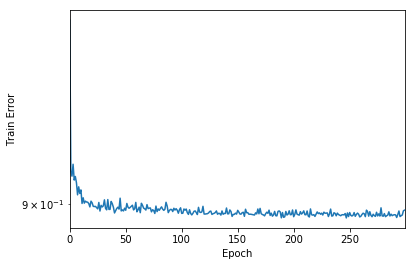

In [11]:
input_ = Input(shape=(100, ))
model = Dense(32, input_shape=(100, ))(input_)
model = Dense(16)(model)
model = Dense(1)(model)

model = Model(input_, model)
model.compile(optimizer=optimizers.Adam(lr=0.001), loss=losses.mean_absolute_error)

history = model.fit(supervised_dataset_train,
                    np.array(mean_normalized_train[[dataset_val_name]]),
                    verbose=0,
                    batch_size=256,
                    epochs=300,
                    shuffle=True)

loss = history.history['loss']
print('\tModel trained with %s = %.4f' % (loss_function_name, loss[-1]))
pd.Series(loss).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

In [15]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

labels = np.array(mean_normalized_train[[dataset_val_name]]).reshape(-1, )
test_labels = np.array(mean_normalized_test[[dataset_val_name]]).reshape(-1, )

clf=RandomForestClassifier(n_estimators=500)
clf.fit(supervised_dataset_train, labels)

y_pred=clf.predict(supervised_dataset_test)
print("MAE:",metrics.mean_absolute_error(test_labels, y_pred))

MAE: 0.9011


In [0]:
# # Save result in to google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

# with open('/content/gdrive/My Drive/file.txt', 'w') as f:
#     f.write('content')
  
# # Download files for local usage
# from google.colab import files
# files.download("data/dm.ckpt.meta") 